# GOP Twitter Sentiment Analysis in Python

#### Created by Kevin 2018 

#### Sentiment Analysis: 

Sentiment analysis (a.k.a. Opinion Ming) refers to the use of natural language processing (NLP), text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

#### NLTK
`nltk` is the most popular Python package for Natural Language processing, it provides algorithms for importing, cleaning, pre-processing text data in human language and then apply computational linguistics algorithms like sentiment analysis.

It also includes many easy-to-use datasets in the `nltk.corpus` package, we can download for example the `movie_reviews` package using the `nltk.download` function:

*   nltk.download("movie_reviews")
*   nltk.download("stopwords"): nltk English stopwords
*   nltk.download("punkt"): nltk tokenizer trained on English 

#### Metadata
Columns:

*   id
*   candidate
*   candidate_confidence
*   relevant_yn
*   relevant_yn_confidence
*   sentiment
*   sentiment_confidence
*   subject_matter
*   subject_matter_confidence
*   candidate_gold
*   name
*   relevant_yn_gold
*   retweet_count
*   sentiment_gold
*   subject_matter_gold
*   text
*   tweet_coord
*   tweet_created
*   tweet_id
*   tweet_location
*   user_timezone

In [0]:
from __future__ import division
import pandas as pd
import numpy as np
import requests
import nltk
import string
import re
import os
from os import path
from PIL import Image
from bs4 import BeautifulSoup
from time import sleep
from collections import Counter
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

## Data Acquisition 
###  Get raw data
In the original dataset, I extracted tweets and sentiment only as they are relevant to my semtiment analysis.   
I could have built pandas data frame, but it has no obvious advantage as most of time I will process text and sentiment separately for this specific purpose.

Import google.colab.drive to add drive mounting capability. Allows us to retrieve information from Google Drive folder.

May need to eventually utilize a Google Drive FUSE Wrapper:

*   https://github.com/dsoprea/GDriveFS
*   https://github.com/astrada/google-drive-ocamlfuse
*   https://pythonhosted.org/PyDrive/

In [10]:
import sys
# Import google.colab.drive to add drive mounting capability
from google.colab import drive
drive.mount('/content/gdrive')
repoPath = "/content/gdrive/My Drive/Colab Notebooks/twitter-sentiment-analysis"
sys.path.append(repoPath)
%cd $repoPath
raw_data = pd.read_csv(repoPath + '/Sentiment.csv', encoding='utf-8')
tweets = raw_data['text']
labels = raw_data['sentiment'] 
print(tweets.head(2))
print(len(tweets),len(labels))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/twitter-sentiment-analysis
pd.read_csv
tweets = raw_data[text]
labels = raw_data[sentiment]
0    RT @NancyLeeGrahn: How did everyone feel about...
1    RT @ScottWalker: Didn't catch the full #GOPdeb...
Name: text, dtype: object
13871 13871


Ok, there are 13871 tweets in the raw dataset. 

## Data Preprocessing (cleaning, wranggling, transforming, ETL)

### Text Data Cleaning 

In [11]:
#Remove all newlines from inside a string
#ref.: https://stackoverflow.com/questions/13298907/remove-all-newlines-from-inside-a-string
clean_tweets = [tweet.replace('\n','').strip() for tweet in tweets]
#To remove all newline characters and then all leading/tailing whitespaces from the string
#Note: strip() only removes the specified characters from the VERY beginning or end of a string. You want to use replace:

#remove the unicodes for the single left and right quote characters - see https://stackoverflow.com/questions/24358361/removing-u2018-and-u2019-character
clean_tweets[:] = [tweet.replace(u'\u2018',"'").replace(u'\u2019',"'") for tweet in clean_tweets] 

#convert abbrevations 
clean_tweets[:] = [tweet.replace('n\'t',' not') for tweet in clean_tweets] #convert n't to  not 

#remove any sub-string containing 'http'
clean_tweets[:] = [re.sub(r"^.*http.*$", '', tweet) for tweet in clean_tweets] 

#remove non-ASCII characters
#see https://stackoverflow.com/questions/20078816/replace-non-ascii-characters-with-a-single-space 
clean_tweets[:] = [re.sub(r'[^\x00-\x7F]+','', tweet) for tweet in clean_tweets] 

#remove tweeter's RT' tags
clean_tweets[:] = [tweet.replace('RT','') for tweet in clean_tweets] 

#make all words lower case
clean_tweets[:] = [tweet.lower() for tweet in clean_tweets] 

clean_tweets[0]

' @nancyleegrahn: how did everyone feel about the climate change question last night? exactly. #gopdebate'

This is what we wanted, but we notice that also punctuation like "?" and words useless for classification purposes like "the" or "did" are also included.
Those words are named "stopwords" and `nltk` has a convenient corpus we can download:

Remove comment in code block below to download the nltk.stopwords corpus for the first time.

In [12]:
#remove comment mark if you'd like to download for the first time
#nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Using the Python string.punctuation list and the English stopwords we can build better features by filtering out those words that would not help in the classification:

The currently used filtering also filters out words like gop, debate, fox, and news as they could be considered "noise" by the ML algorithm used to determine sentiment. This is because these words are used in tweets with both positive and negative connotation.

In [34]:
#here I customised the useless words by adding these: 'gop', 'debate', 'gopdebate', 'news' as they are 'neutral' and exist in both positive and negative tweets, won't give any insights; instead, they are likely 'noise' to ML algo.
useless_ones = nltk.corpus.stopwords.words("english") + list(string.punctuation) + ['``', "''",'gop','debate','gopdeb','gopdebate','gopdebates','fox','news','foxnew','foxnews', 'amp']
#useless_ones = nltk.corpus.stopwords.words("english") + list(string.punctuation)
useless_ones[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### Text Tokenizing and Removing Stopwords & Punctuations 

`nltk` has a sophisticated word tokenizer trained on English named `punkt`, we first have to download its parameters:

Remove comment in code block below to download the nltk.punkt corpus for the first time.

In [18]:
#remove comment mark if you'd like to download for the first time
#nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
#tokenize and clean up the whole set of tweet texts (tokenized and cleaned tweets: tc_tweets)
tc_tweets = []
for tweet in clean_tweets:
  wordlist = [word for word in nltk.word_tokenize(tweet) if word not in useless_ones] #a list of words per tweet
  tc_tweets.append(wordlist)
tc_tweets[0] 

['nancyleegrahn',
 'everyone',
 'feel',
 'climate',
 'change',
 'question',
 'last',
 'night',
 'exactly']

### Text Stemming

'ntlk' has a stemming algorithm that we use to normalize the text of the tweets. This stemming while change words like "waited", "waits", and "waiting" to "wait". This helps clean the data and make it easier for the ML algorithm.

In [25]:
#apply stemming - you can use other stemming algo
sno = nltk.stem.SnowballStemmer('english')
tc_tweets_stemmed = []
for words in tc_tweets:
  stemmed_words = [sno.stem(word) for word in words]
  tc_tweets_stemmed.append(stemmed_words)
tc_tweets[:] = tc_tweets_stemmed
print(tc_tweets[0])

['nancyleegrahn', 'everyon', 'feel', 'climat', 'chang', 'question', 'last', 'night', 'exact']


## Exploratory Study & Data Visualisation

### Plotting Frequencies of Words

It is common to explore a dataset before starting the analysis, in this section we will find the most common words and plot their frequency.

We can extract the words from the entire set of reviews.

In [31]:
#Making a flat list out of list of lists in Python
#ref.: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
all_words = [item
              for sublist in tc_tweets
              for item in sublist]
len(all_words)

95824

The `collection` package of the standard library contains a `Counter` class that is handy for counting frequencies of words in our list.  
It also has a most_common() method to access the words with the higher count:  

In [32]:
word_counter = Counter(all_words)
most_common_words = word_counter.most_common(10)
most_common_words

[('rwsurfergirl', 1975),
 ("'s", 1641),
 ('trump', 1494),
 ('candid', 945),
 ('realdonaldtrump', 891),
 ('question', 664),
 ('...', 652),
 ('like', 641),
 ('get', 632),
 ('night', 584)]

We can sort the word counts and plot their values on Logarithmic axes to check the shape of the distribution. This visualization is particularly useful if comparing 2 or more datasets, a flatter distribution indicates a large vocabulary while a peaked distribution a restricted vocabulary often due to a focused topic or specialized language.

In [33]:
sorted_word_counts = sorted(word_counter.values(),reverse=True)
#sorted_word_counts = sorted(list(word_counter.values()), reverse=True)
sorted_word_counts[:10]

[1975, 1641, 1494, 945, 891, 664, 652, 641, 632, 584]

Text(0.5, 1.0, 'Word Rank for GOP Twitters')

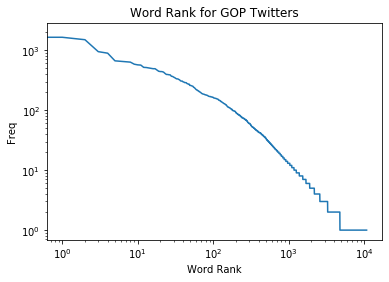

In [35]:
plt.loglog(sorted_word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('Word Rank for GOP Twitters')

Another related plot is the histogram of sorted_word_counts, which displays how many words have a count in a specific range.

Of course the distribution is highly peaked at low counts, i.e. most of the words appear which a low count, so we better display it on semilogarithmic axes to inspect the tail of the distribution.

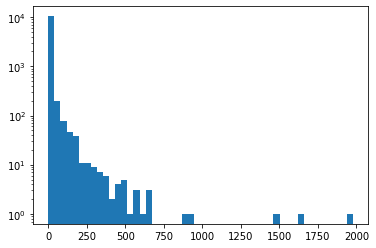

In [36]:
plt.hist(sorted_word_counts, bins=50, log=True);

### Visualise Positives vs. Negatives Ratio

In [37]:
# determine count of tweets with particular sentiment based on label
# labels included in the data are positive, neutral, and negative
label_count=pd.Series(labels).value_counts()
label_count

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [41]:
# calculate ratio of positive, neutral, and negative tweets and print
review_ratio = [opinion/sum(label_count)*100 for opinion in label_count]
print('Sentiment Ratio: ', review_ratio)
Pos_ratio = label_count['Positive']/sum(label_count)*100
print('Positive comments ratio: {0}%'.format(Pos_ratio))
Neu_ratio = label_count['Neutral']/sum(label_count)*100
print('Neutral comments ratio: {0}%'.format(Neu_ratio))
Neg_ratio = label_count['Negative']/sum(label_count)*100
print('Negative comments ratio: {0}%'.format(Neg_ratio))

Sentiment Ratio:  [61.22846225939009, 22.651575228894817, 16.119962511715087]
Positive comments ratio: 16.119962511715087%
Neutral comments ratio: 22.651575228894817%
Negative comments ratio: 61.22846225939009%


Plot a bar chart of the sentiment label vs. percentage ratio.

Text(0.5, 1.0, 'Sentiment Ratio for GOP Twitters')

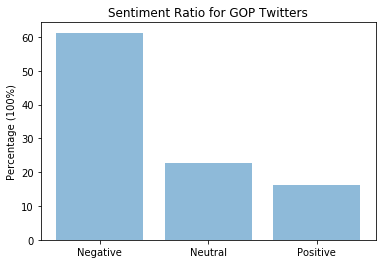

In [44]:
#plot a bar chart of the sentiment label vs. percentrage ratio
y_pos = range(len(label_count))
#plt.bar(y_pos,label_count,align='center', alpha=.5)
plt.bar(y_pos,review_ratio,align='center', alpha=.5)
plt.xticks(y_pos,label_count.index)
plt.ylabel('Percentage (100%)')
plt.title('Sentiment Ratio for GOP Twitters')

### Build WordCloud for GoP Twitter

In [45]:
# pairs each tweet's cleaned text with its sentiment label
text_label_pair_list = list(zip(tc_tweets,labels))
text_label_pair_list[0]

(['nancyleegrahn',
  'everyon',
  'feel',
  'climat',
  'chang',
  'question',
  'last',
  'night',
  'exact'],
 'Neutral')

In [48]:
#remove those neutral tweets as I am only interested in neg / pos ones
text_label_pair_list[:] = [tuple for tuple in text_label_pair_list if tuple[1]!='Neutral']
text_label_pair_list[1]

(['robgeorg',
  'car',
  'fiorina',
  'trend',
  '--',
  'hour',
  '--',
  'men',
  'just-complet',
  'say',
  "'s"],
 'Positive')

In [49]:
#split into train and test set, 90% for training set, 10% reserved for testing and evaluation
train, test = train_test_split(text_label_pair_list, test_size = .1, random_state=7)
print(train[0])
print(test[0])

(['rwsurfergirl', 'thank', 're', 'rai', 'realdonaldtrump', "'s", 'rate'], 'Positive')
(['fieldnegro', 'respect', 'life', '...', '.just', 'black', 'one'], 'Negative')


In [52]:
train_pos = [tuple for tuple in text_label_pair_list if tuple[1]=='Positive']
train_neg = [tuple for tuple in text_label_pair_list if tuple[1]=='Negative']
print(train_pos[1])
print(train_neg[1])

(['robgeorg', 'car', 'fiorina', 'trend', '--', 'hour', '--', 'men', 'just-complet', 'say', "'s"], 'Positive')
(['deer', 'headlight', 'lizzwinstead', 'ben', 'carson', 'may', 'brain', 'surgeon', 'perform', 'lobotomi'], 'Negative')


In [55]:
#unzip texts
train_pos_texts, _ = list(zip(*train_pos))
train_neg_texts, _ = list(zip(*train_neg))
print(train_pos_texts[1])
print(train_neg_texts[1])

['robgeorg', 'car', 'fiorina', 'trend', '--', 'hour', '--', 'men', 'just-complet', 'say', "'s"]
['deer', 'headlight', 'lizzwinstead', 'ben', 'carson', 'may', 'brain', 'surgeon', 'perform', 'lobotomi']


In [59]:
train_pos_texts_str = ' '.join([word for sublist in train_pos_texts
                                        for word in sublist])
train_neg_texts_str = ' '.join([word for sublist in train_neg_texts
                                        for word in sublist])
print(train_pos_texts_str[:50])
print(train_neg_texts_str[:50])

robgeorg car fiorina trend -- hour -- men just-com
deer headlight lizzwinstead ben carson may brain s


In [60]:
def create_wordcloud_with_mask (data):
    # read the mask image
    usa_mask = np.array(Image.open(path.join("/kaggle/input/usamap/usa_map.jpg")))
    wcloud = WordCloud(max_words=1000,
                       mask=usa_mask,
                       stopwords=set(STOPWORDS),
                       background_color='white',
                       contour_width=3,
                       contour_color='steelblue')
    #create word cloud
    wcloud.generate(data)
    #display
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wcloud, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
print("Positive comments in training set")
create_wordcloud_with_mask(train_pos_texts_str)
print("Negative comments in training set")
create_wordcloud_with_mask(train_neg_texts_str)

Positive comments in training set


FileNotFoundError: ignored

## Build BOW (Bag-of-Words) Model

The simplest model for analyzing text is just to think about text as an unordered collection of words (bag-of-words). This can generally allow to infer from the text the category, the topic or the sentiment.

From the bag-of-words model we can build features to be used by a classifier, here we assume that each word is a feature that can either be `True` or `False`.
We implement this in Python as a dictionary where for each word in a sentence we associate `True`, if a word is missing, that would be the same as assigning `False`.

In [0]:
def build_bow_features(words):
    return {word:True for word in words}

In [0]:
#build a list of tuples (BOW_dict, label) for all tweets
train_bow = [(build_bow_features(tuple[0]), tuple[1]) for tuple in train]
test_bow = [(build_bow_features(tuple[0]), tuple[1]) for tuple in test]

In [0]:
print(len(train_bow),len(test_bow))

## Train a Classifier for Sentiment Analysis

#### Naive Bayes
One of the simplest supervised machine learning classifiers is the Naive Bayes Classifier, it can be trained on 90% of the data to learn what words are generally associated with positive or with negative comments.

In [0]:
sentiment_classifier = NaiveBayesClassifier.train(train_bow)

We can check after training what is the accuracy on the training set, i.e. the same data used for training, we expect this to be a very high number because the algorithm already "saw" those data. Accuracy is the fraction of the data that is classified correctly, we can turn it into percent:

In [0]:
nltk.classify.util.accuracy(sentiment_classifier, train_bow)*100

#### Evaluate model accuracy on the test set

The accuracy above is mostly a check that nothing went very wrong in the training, the real measure of accuracy is on the remaining 10% of the data that wasn't used in training, the test data:

In [0]:
nltk.classify.util.accuracy(sentiment_classifier, test_bow)*100

In [0]:
test_comment_dicts, test_labels = list(zip(*test_bow))
preds = [sentiment_classifier.classify(comment_dict) for comment_dict in test_comment_dicts]
pred_vs_observ = pd.DataFrame(np.array([test_labels,preds]).T,columns=['observation','prediction'])
pred_vs_observ.transpose()

In [0]:
#print confusion matrix
print(confusion_matrix(test_labels, preds))

Accuracy here is around 81% which is pretty good for such a simple model if we consider that the estimated accuracy for a person is about 80%. We can finally print the most informative features, i.e. the words that mostly identify a positive or a negative review:

In [0]:
sentiment_classifier.show_most_informative_features(100)

## Summary
1. NLTK is a handy and powerful tool to do NLP in Python
2. Accuracy is reasonably good using Naive Bayes classifier 
3. If we want to further improve accuracy, a few options to consider: 
	- The model has to become smarter to recognize text context and noise. For example, for this negative tweeter: "new game! 1 person can\'t win. players close eyes; try to find them by saying "marco", waiting for the loser to reply", the separate 'positive' words like 'win', 'new' and 'marco' might made the model to mistakenly predict it as positive.
	- Apply NN Deep Learning like RNN and LSTM techniques to better model the texts 
    
    